In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()

In [ ]:
height, width = 128, 128

[(3, 36, 2, 28, 28), (8, 30, 69, 28, 28)]


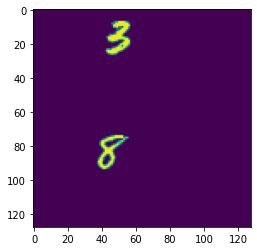

In [ ]:
def make_img(x_array, y_array, height, width):
  new_img = np.zeros([height, width])
  mask = np.zeros([height, width])
  old_height = x_array.shape[1]
  old_width = x_array.shape[2]
  all_num = 2
  num = 0
  shifts = []
  while num < all_num:
    x_shift = random.randint(0, width-old_width)
    y_shift = random.randint(0, width-old_height)
    idx = random.randint(0, x_array.shape[0]-1)
    if (mask[y_shift: y_shift+old_height, x_shift: x_shift+old_height]==0).all():
      new_img[y_shift: y_shift+old_height, x_shift: x_shift+old_height] = x_array[idx]
      mask[y_shift: y_shift+old_height, x_shift: x_shift+old_height] = 1
      shifts.append((y_array[idx], x_shift, y_shift, 28, 28))
      num +=1
  return new_img, shifts

s = make_img(x_train, y_train, height, width)
plt.imshow(s[0])
print(s[1])
#plt.gca().add_patch(matplotlib.patches.Rectangle((s[2][0]),28,28, ec='r', fc='none'))

In [ ]:
imgs = []
labels = []
for i in tqdm(range(40000)):
  sample = make_img(x_train, y_train, height, width)
  imgs.append(sample[0])
  labels.append(sample[1])

100%|██████████| 40000/40000 [00:05<00:00, 7607.98it/s]


In [ ]:
labels[0]

[(4, 77, 34, 28, 28), (0, 66, 81, 28, 28)]

In [ ]:
#the sample is a square
#test parameters

#height, width = 128, 128
stride = 10
size = 28
padding = 4
n_rows = 10
n_cols = 10

dist_threshold = 20

#formula to big padding
big_padding = int((((size+2*padding)+stride*n_rows)-height)/2)

print("sample size with padding: ", height+2*big_padding)
print("box size with padding: ", size+2*padding)
print("stride: ", stride)
print("number of iteration in rows/cols: ", n_rows)

sample size with padding:  136
box size with padding:  36
stride:  10
number of iteration in rows/cols:  10


In [ ]:
from math import sqrt

def kardashian_dist(labels, h, w):
    # 1. get coords
    # 2. count distance
    # 3. return smallest distance
    distances = []
    # example labels:
    # [(3, 22, 31, 28, 28), (9, 81, 46, 28, 28)]
    for i, label in enumerate(labels):
        x = label[1]
        y = label[2]
        # a^2 + b^2 = c^2
        # c = sqrt(a^2 + b^2)
        distance = sqrt((h - y)**2 + (w - x)**2)
        distances.append((i, distance))
    distances.sort(key=lambda x: x[1])

    return distances[0]

In [ ]:
def  random_labels():
    #(0, 66, 81, 28, 28)
    return (random.randint(0,9), random.randint(size/2, height-size/2), random.randint(size/2, width-size/2), 28, 28)

In [ ]:
random_labels()

(9, 96, 93, 28, 28)

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import mse

In [ ]:
def step(X, y):
    for row in range(n_rows):
        for col in range(n_cols):
            #change names
            box_height = (size+2*padding)/2+stride*row
            box_width = (size+2*padding)/2+stride*col

            distance = kardashian_dist(y, box_height, box_width)
            sliced_X = X[row*stride: row*stride+36, col*stride: col*stride+36, :]
            print(sliced_X.shape)

            if dist_threshold >= distance[1]:
                flag = [1,0]
                label = y[distance[0]]

            else:
                flag = [0,1]
                label = random_labels()

            with tf.GradientTape() as tape:
                pred = model(sliced_X)
                confidence_loss = binary_crossentropy(flag, pred[1])
                if pred[1][0] >= 0.5:
                    clfs_loss = sparse_categorical_crossentropy(label[0], pred[0])
                    mse_loss = mse(label[1:], pred[2])
                    grads = tape.gradient([clfs_loss, confidence_loss, mse_loss], model.trainable_variables)
                    opt.apply_gradients(zip(grads, model.trainable_variables))
                else:
                    grads = tape.gradient(confidence_loss, model.trainable_variables)
                    opt.apply_gradients(zip(grads, model.trainable_variables))  

                #grads = tape.gradient(loss, model.trainable_variables)
                #opt.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
binary_crossentropy(flag, pred[1])

In [ ]:
X = tf.random.uniform(shape=(1, 36, 36, 1))
for layer in model.layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

InputLayer output shape:	 (1, 36, 36, 1)
Conv2D output shape:	 (1, 36, 36, 16)
MaxPooling2D output shape:	 (1, 18, 18, 16)
Conv2D output shape:	 (1, 18, 18, 32)
MaxPooling2D output shape:	 (1, 9, 9, 32)
Conv2D output shape:	 (1, 9, 9, 64)
MaxPooling2D output shape:	 (1, 4, 4, 64)
Conv2D output shape:	 (1, 4, 4, 128)
Flatten output shape:	 (1, 2048)
Dense output shape:	 (1, 128)
Dropout output shape:	 (1, 128)
Dense output shape:	 (1, 128)
Dropout output shape:	 (1, 128)
Dense output shape:	 (1, 10)


ValueError: ignored

In [ ]:
for x,y in zip(imgs, labels):
    step(x,y)
    break

(36, 36, 1)


ValueError: ignored

In [ ]:
imgs = np.array(imgs)

In [ ]:
imgs = imgs.reshape(-1, 128, 128, 1)

In [ ]:
labels = np.array(labels)


In [ ]:
imgs.shape

(40000, 128, 128, 1)

#kiedy jest cyfra
    cyfry powinny być posortowane
    jeśli współrzędne są w kwadracie dodaj właściwy label
    predykcja confidence
    strata dla regresji powinna być mała
    klasyfikacja


#kiedy nie ma cyfry
    współrzędne nie są w kwadracie dodaj random label
    predykcja confidence
    nie liczymy straty regresji i klasyfikacji

In [ ]:
imgs.shape

(40000, 128, 128, 1)

In [ ]:
imgs = np.array(imgs)
labels = np.array(labels)

In [ ]:
imgs = imgs/255

In [ ]:
labels = labels.reshape(40000, -1)

In [ ]:
imgs = imgs.reshape(40000,96,96,1)

In [ ]:
labels.shape

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten

inp = Input([36,36,1])
x = inp
x = Conv2D(16, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
# x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
clfs = Dense(10, activation="softmax")(x)
confidence = Dense(2, activation="softmax")(x)
reg = Dense(4, activation="linear")(x)

model = Model(inputs=inp, outputs=[clfs, confidence, reg])



In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 36, 36, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 36, 36, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 18, 18, 16)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 18, 18, 32)   4640        max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [ ]:


model.compile(optimizer='adam', loss=[SparseCategoricalCrossentropy(from_logits=True),
                                      "binary_crossentropy",
                                      'mse'])

In [ ]:
model.summary()

In [ ]:
#model.fit(imgs, labels, epochs=5, batch_size=64)

In [ ]:
model.predict(imgs[1].reshape(1,96,96,1))

In [ ]:
labels[1]